## PySP2

PySP2 is a Python package for processing data from Droplet Measurement Technologies' Single Particle Soot Photometer (SP2). 

The goals (and advantages) of PySP2 are:

    * Bring DMT's processing code, originally written in IGOR, to open source in Python.
    
    * Be interactable with Dask for parallelizing SP2 processing on clusters such as ARM Cumulus Cluster. 
    
PySP2 is capable of:

    * Processing raw SP2 data from DMT in .sp2b format
    
    * Generating wave properties from each channel
    
    * Genetering particle mass and size distributions from the particle properties.

In [1]:
import act
import pysp2
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Loading the SP2 data

PySP2 has two procedures for reading in the probe configuration in a .ini file as well as reading an .sp2b file. Here, we load a sample time period from the SP2.

In [2]:
config = pysp2.io.read_config('20181110/20181110114046.ini')
in_sp2b = pysp2.io.read_sp2('20181110/20181110x001.sp2b', arm_convention=False)

In [80]:
list(config.keys())

['DEFAULT',
 'Versions',
 'Program',
 'Controllers',
 'Alarms',
 'Alicat Flow Controller',
 'Control',
 'SPAT',
 'Acquisition',
 'Digital',
 'Laser',
 'Analog Input',
 'Housekeeping',
 'Streaming Data',
 'Flow Meters',
 'Calculated Channels',
 'Calculations',
 'Missing Value']

# SP2 raw outputs

The SP2 has 8 different photodiode detector arrays that measure the scattering and incandescence signals from the laser shining onto a partilcle that enters the beam. A refractory black carbon particle would, first, scatter the laser beam back to the detector. Applying Mie theory to the scattering signal gives us the approximate diameter of the particle entering the beam. Channels 0 (high gain) and 1 (low gain) measure the strength of this signal along a photodiode array that is aligned along the direction of the sample flow. In essence, the position along the photodiode array is proportional to the time at which the particle scatters light after it enters the laser beam. The low gain channel signal is useful for when the high gain channel is saturated from large particles entering the SP2 sample volume. 

However, after the non-black carbon material coating the particle is evaporated by the heat from the laser, the black carbon proceeds to incandesce. The SP2 then records the signal into ch4 (high gain channel) and ch5 (low gain channel). This is done for one of every *x* number of partciles, where this *x* can be set by the user while operating the SP2. Most of the time, this is set to 5, since recording every particle would take up too much storage and processing time.

These raw waveforms for each particle are stored into an xarray dataset, shown below.

In [68]:
in_sp2b

<xarray.Dataset>
Dimensions:          (event_index: 50014, columns: 100)
Dimensions without coordinates: event_index, columns
Data variables: (12/19)
    time             (event_index) datetime64[ns] 2018-11-10T12:12:29.942383 ...
    Flag             (event_index) int16 16 16 32 24 16 32 ... 16 32 16 16 32 16
    Res1             (event_index) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Res5             (event_index) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Res6             (event_index) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Res7             (event_index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...               ...
    Data_ch2         (event_index, columns) int64 -29252 -29264 ... -29196
    Data_ch3         (event_index, columns) int64 -176 -356 32 ... 5368 4972
    Data_ch4         (event_index, columns) int64 -28352 -28348 ... -28376
    Data_ch5         (event_index, columns) int64 -29080 -29084 ... -29080
    Data_ch6         (event_index, columns) int64 -29256 -29256 ... -29248
    Data_ch7         (event_index, columns) int64 16 32 -4 0 ... -560 -544 -500

Let's take the first particle in this file and plot the raw signals recorded by the SP2. First, we will look at the high gain scattering (ch0) and low gain scattering (ch4) signals.

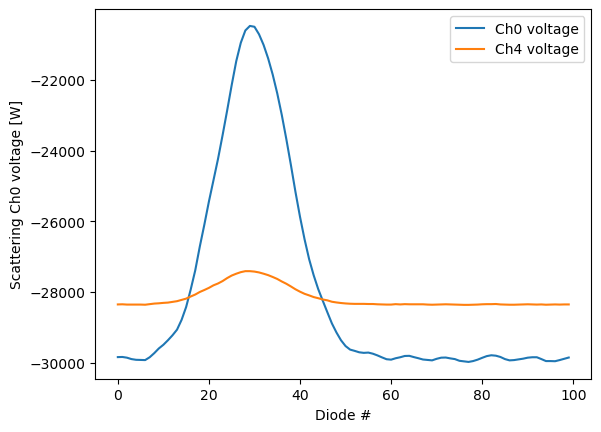

In [69]:
in_sp2b["Data_ch0"].sel(event_index=10).plot(label='Ch0 voltage')
in_sp2b["Data_ch4"].sel(event_index=10).plot(label='Ch4 voltage')
plt.ylabel('Scattering Ch0 voltage [W]')
plt.xlabel('Diode #')
plt.legend()

As we can see here, the peak of the scattering signal (ch0) is at around diode 32 with a Gaussian shape. In the low gain scattering channel (ch4), we see a similar peak with a much smaller magnitude since these diodes are less sensitive to the amount of scattered light from the laser beam.

## Obtaining waveform statistics

The next step is to obtain the characteristics of these waveforms such as the peak amplitude, noise floor, and half width for each channel. In addition, Gaussian fits are generated for ch0 and ch4 since these waveforms are Gaussian if there is a single particle in the sample volume. These are the characteristics that PySP2 uses to derive particle mass and size distributions. 

In [70]:
particle_statistics = pysp2.util.gaussian_fit(in_sp2b, config)

/Users/rjackson/PySP2/pysp2/util/peak_fit.py:452: RuntimeWarning: divide by zero encountered in divide
  peak2area = np.max(data2, axis=1)/denominator


Processing record 0


/Users/rjackson/mambaforge/envs/act_env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing record 1000
Processing record 2000
Processing record 3000
Processing record 4000
Processing record 5000
Processing record 6000
Processing record 7000
Processing record 8000
Processing record 9000
Processing record 10000
Processing record 11000
Processing record 12000
Processing record 13000
Processing record 14000
Processing record 15000
Processing record 16000
Processing record 17000
Processing record 18000
Processing record 19000
Processing record 20000
Processing record 21000
Processing record 22000
Processing record 23000
Processing record 24000
Processing record 25000
Processing record 26000
Processing record 27000
Processing record 28000
Processing record 29000
Processing record 30000
Processing record 31000
Processing record 32000
Processing record 33000
Processing record 34000
Processing record 35000
Processing record 36000
Processing record 37000
Processing record 38000
Processing record 39000
Processing record 40000
Processing record 41000
Processing record 42000
P

/Users/rjackson/PySP2/pysp2/util/peak_fit.py:76: RuntimeWarning: Mean of empty slice
  ratio = np.nanmean(


50014 records processed in 52.92566895484924 s


These particle statistics are then stored in an xarray dataset for each particle.

In [30]:
particle_statistics

<xarray.Dataset>
Dimensions:              (event_index: 1106, columns: 100)
Dimensions without coordinates: event_index, columns
Data variables: (12/81)
    time                 (event_index) datetime64[ns] 2018-11-10T12:12:29.942...
    Flag                 (event_index) int16 16 16 32 24 16 ... 16 32 24 16 32
    Res1                 (event_index) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Res5                 (event_index) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Res6                 (event_index) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Res7                 (event_index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                   ...
    IncanPkOffsetch1ch2  (event_index) float64 -15.0 nan -12.0 ... -8.0 46.0
    IncanPkOffsetch5ch6  (event_index) float64 65.0 -2.0 53.0 ... -6.0 18.0 46.0
    IncanRatioch1ch2     (event_index) float64 0.9432 nan ... 0.9399 0.3937
    IncanRatioch5ch6     (event_index) float64 0.45 nan 15.17 ... 0.7391 0.4266
    ScatRejectKey        (event_index) int64 0 0 0 0 0 1 2 0 ... 2 3 0 0 0 0 0 6
    IncanRejectKey       (event_index) int64 2 1 9 0 2 0 0 2 ... 2 2 2 0 2 2 10

PySP2 has a handy function to check your particle fits called *pysp2.vis.plot_wave*. We will plot the fit characteristics for the particle we plotted above. As we can see, the particle wave-form is narrower than a Gaussian fit. However, the peak amplitude is represented well by the fit. Let's replot the ch0 and ch4 waves using this capability.

/Users/rjackson/ACT/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


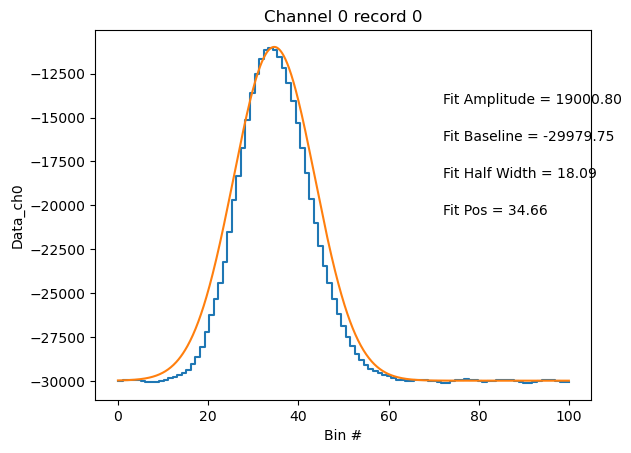

In [75]:
pysp2.vis.plot_wave(particle_statitics, 0, 0)

/Users/rjackson/ACT/act/plotting/plot.py:81: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


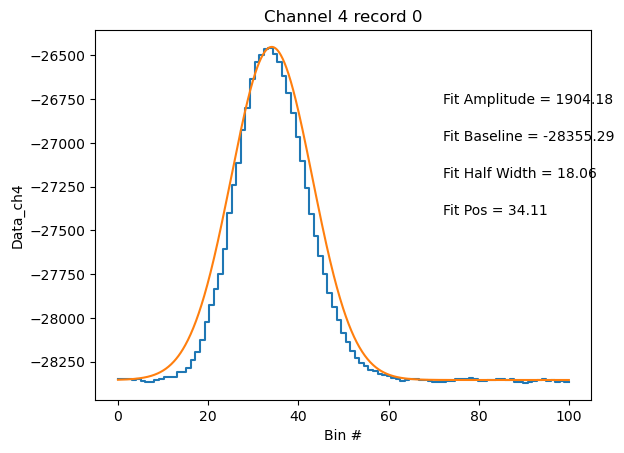

In [76]:
pysp2.vis.plot_wave(particle_statitics, 0, 4)

Finally, we can save these particle statistics to either a netCDF file or a .dat file that is readable by DMT's IGOR-based processing software. PySP2 also supports loading .dat files made by IGOR's software, enabling users to seamlessly read already-processed data from the IGOR-based code.

In [71]:
# Save to the IGOR .dat format
pysp2.io.write_dat(particle_statistics, '20181110x001.dat')

We use the pysp2.io.read_dat function to read in IGOR .dat files. Wildcards are supported, enabling concatenation of particle datasets for further processing. Let's load in some previously processed data!

In [3]:
part_stats = pysp2.io.read_dat('20181110/20181110x*.dat', type='particle')
part_stats

<xarray.Dataset>
Dimensions:              (index: 750446)
Coordinates:
  * index                (index) int64 0 1 2 3 4 ... 50031 50032 50033 50034
Data variables: (12/69)
    TimeWave             (index) float64 4.395e+04 4.395e+04 ... 4.678e+04
    DateTimeWaveUTC      (index) float64 3.625e+09 3.625e+09 ... 3.625e+09
    DateTimeWave         (index) float64 3.625e+09 3.625e+09 ... 3.625e+09
    EventIndex           (index) int64 12029 19482 21720 ... 480511 490469
    Flag                 (index) int64 16 16 32 24 16 32 ... 32 16 16 24 16 32
    Base_ch0             (index) float64 -2.998e+04 -2.951e+04 ... -2.953e+04
    ...                   ...
    IncanRatioch5ch6     (index) float64 0.4502 nan 15.16 ... 5.4 -1.182 13.16
    IncanPkOffsetch5ch6  (index) float64 65.0 -2.0 53.0 2.0 ... 48.0 40.0 -16.0
    IncanRatioch1ch2     (index) float64 0.9432 nan 181.8 ... nan 0.925 39.72
    IncanPkOffsetch1ch2  (index) float64 -15.0 nan -12.0 1.0 ... 28.0 0.0 -15.0
    ScatRejectKey        (index) int64 0 0 2 0 0 2 2 0 2 0 ... 2 0 0 2 0 0 0 0 2
    IncanRejectKey       (index) int64 2 1 0 0 2 0 0 2 0 2 ... 0 1 2 0 2 2 2 2 0
Attributes:
    _datastream:          20181110x002.dat
    _site:                201
    _arm_standards_flag:  0

## Reading and plotting housekeeping data

PySP2 also supports reading the housekeeping variables saved by the SP2 for diagnostics. If these files are saved in a .hk file that is output by the SP2, PySP2 will read these characteristics into an xarray dataset that can be viewed.

In [4]:
hk_ds = pysp2.io.read_hk_file('20181110/20181110114047.hk')
hk_ds

<xarray.Dataset>
Dimensions:                    (time: 14799)
Coordinates:
  * time                       (time) datetime64[ns] 2018-11-10T11:40:48.3000...
Data variables: (12/46)
    Time                       (time) float64 4.205e+04 4.205e+04 ... 5.685e+04
    Sample Flow LFE            (time) float64 -4.558 -3.67 ... 177.0 143.6
    YAG Power                  (time) float64 -0.029 -0.022 ... -0.027 -0.026
    Incand. Conc.              (time) float64 nan 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sheath Flow Read           (time) float64 -13.35 -10.43 ... 995.5 998.2
    YAG Crystal Temp           (time) float64 28.42 28.88 27.48 ... 29.06 29.04
    ...                         ...
    Num of Particles           (time) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Num Written to File        (time) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Num in File                (time) int64 0 0 0 0 ... 48332 48332 48332 48332
    Laser Power Switch         (time) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Sample Pump Power Switch   (time) int64 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 0 0 0
    Laser Temp                 (time) float64 nan 0.9572 ... 0.9572 0.9572
Attributes:
    _datastream:          20181110114047.hk
    _site:                201
    _arm_standards_flag:  0

Let's use xarray's plotting tools to view the Sample Flow Rate into the SP2 for the day.

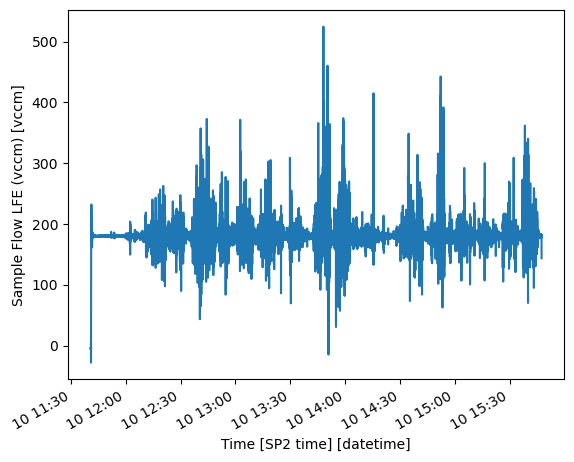

In [102]:
hk_ds["Sample Flow LFE"].plot()

## Obtaining particle size distributions

In this section, we'll go over how to calculate and plot mass and number concentrations and size distributions.
Often, the SP2 will need to be calibrated in order to ensure that mass and number size distributions are properly calculated. Thankfully, PySP2 has a DMTGlobals class that enables
seamless loading of calibration files.

In [5]:
DGlbals = pysp2.util.DMTGlobals('20181110/Unit24CAL_Aldine_final.txt')

Let's process the particle sizes and masses using the calibration we loaded.

In [21]:
psd = pysp2.util.calc_diams_masses(part_stats)

/Users/rjackson/PySP2/pysp2/util/particle_properties.py:38: RuntimeWarning: All-NaN slice encountered
  PkHt_ch0 = np.nanmax(np.stack([input_ds['PkHt_ch0'].values, input_ds['FtAmp_ch0'].values]), axis=0)
/Users/rjackson/PySP2/pysp2/util/particle_properties.py:39: RuntimeWarning: All-NaN slice encountered
  PkHt_ch4 = np.nanmax(np.stack([input_ds['PkHt_ch4'].values, input_ds['FtAmp_ch4'].values]), axis=0)


Number of scattering particles accepted = 638017
Number of scattering particles rejected for min. peak height = 26642
Number of scattering particles rejected for peak width = 12482
Number of scattering particles rejected for fat peak = 0
Number of scattering particles rejected for peak pos. = 30819


In [22]:
psds = pysp2.util.process_psds(psd, hk_ds, config, num_bins=199)
psds

<xarray.Dataset>
Dimensions:            (time: 1479, num_bins: 199)
Coordinates:
  * time               (time) datetime64[ns] 2018-11-10T11:40:48.300000 ... 2...
  * num_bins           (num_bins) float64 0.01 0.015 0.02 ... 0.99 0.995 1.0
Data variables: (12/17)
    DateTimeWaveUTC    (time) float64 3.625e+09 3.625e+09 ... 3.625e+09
    NumConcIncan       (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NumConcIncanScat   (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NumConcTotal       (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NumConcScatSat     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NumConcScat        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                 ...
    ScatNumEnsemble    (time, num_bins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ScatMassEnsemble   (time, num_bins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    IncanNumEnsemble   (time, num_bins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    IncanMassEnsemble  (time, num_bins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ScatNumEnsembleBC  (time, num_bins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NumFracBC          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Let's view the number concentrations. Since we have only processed about five minutes of 
data for this example, we will zoom into the processed data.

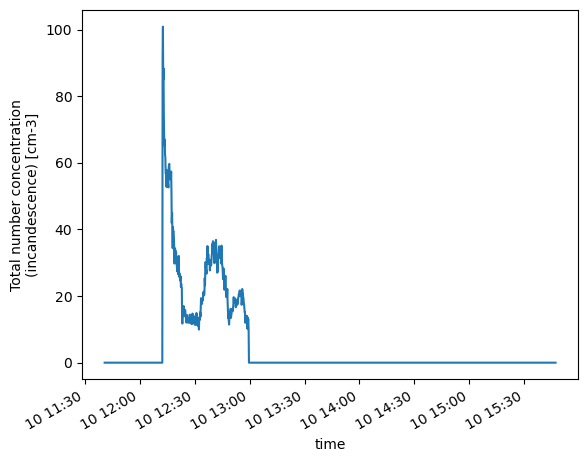

In [23]:
psds.NumConcIncan.plot()

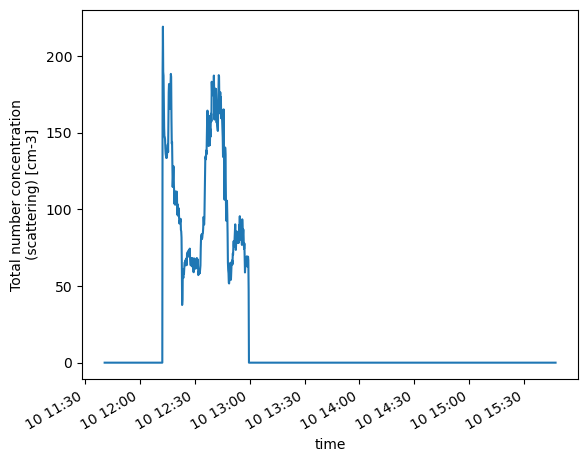

In [10]:
psds.NumConcScat.plot()

Let's take a look at the particle size distributions!

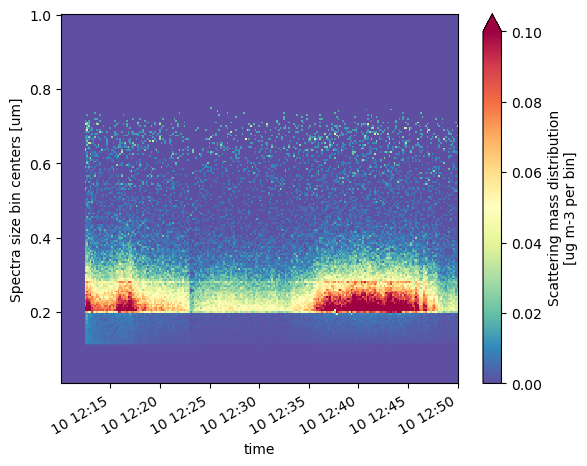

In [33]:
psds.ScatMassEnsemble.T.sel(time=slice('2018-11-10T12:10:00', '2018-11-10T12:50:00')).plot(vmin=0, vmax=0.1, cmap='Spectral_r')

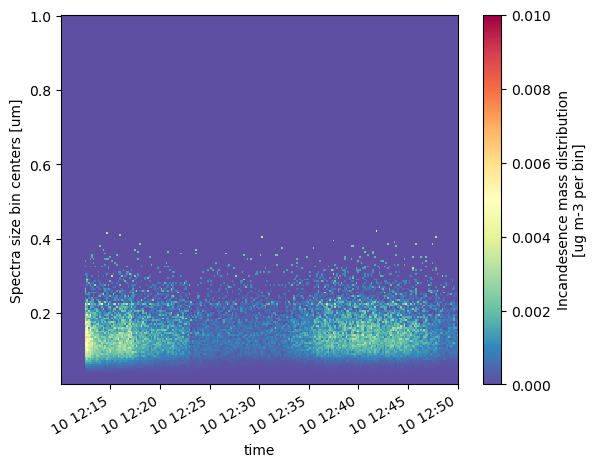

In [28]:
psds.IncanMassEnsemble.T.sel(time=slice('2018-11-10T12:10:00', '2018-11-10T12:50:00')).plot(vmin=0, vmax=0.01, cmap='Spectral_r')